# Prepare the environment

Setup the `matplotlib` environment to look pretty.

In [1]:
import matplotlib.pyplot
# Show the plots inside the notebook.
%matplotlib inline
# Make the figures high-resolution.
%config InlineBackend.figure_format='retina'
# Various font sizes.
ticksFontSize=18
labelsFontSizeSmall=20
labelsFontSize=30
titleFontSize=34
legendFontSize=14
matplotlib.rc('xtick', labelsize=ticksFontSize) 
matplotlib.rc('ytick', labelsize=ticksFontSize)
# Colourmaps.
cm=matplotlib.pyplot.cm.get_cmap('viridis')

# Introduction

Prepare pristine time series of mean motion $n$, inclination $i$ and eccentricity $e$ (use a related quantity, perigee radius $r_p=(1-e)a$) on which the individual filters will be tested. The required steps are:

1. Load TLE orbital elements.
2. Filter out corrected TLEs.
3. Run a moving window with a robust polynomial through the TLE values and save the time series of the values of this polynomial at the epochs of the TLEs.
4. Re-sample the time series at equally spaced epochs.

## Script controls

Choose the whether to automatically save figures besides showing them, save the raw data, and which object to analyse.

In [2]:
SSC=13025 # Will work with this object

# Load TLEs

Do not parse the TLEs because that requires a parser function, which forms a part of the proprietary ESA code. Load already parsed elements extracted from the TLEs.

In [3]:
import os, numpy

meanMotions=numpy.load('{}MeanMotions.npy'.format(SSC))
eccentricities=numpy.load('{}eccentricities.npy'.format(SSC))
inclinations=numpy.load('{}inclinations.npy'.format(SSC))
epochsJD=numpy.load('{}epochsJD.npy'.format(SSC),)
epochs=numpy.load('{}epochs.npy'.format(SSC))
print("Read {} TLEs for {}.".format(meanMotions.size,SSC))

Read 2224 TLEs for 13025.


# Pre-process the TLEs

Need to remove corrected TLEs from the time series, they will make resampling produce dodgy results.

In the case of `13025` object, also remove the last TLE - it would be marked as an epoch outlier by `findNAndTOutliersAndSeqeunces` but we won't be running the filters here, so need to remove that TLE manually.

The function to fitler corrected TLEs forms part of a proprietary code. However, its resuls for `13025` have been saved to `npy` files to allow the results to be reproduced. `outlierFlags` equal to 1 correspond to TLEs that are followed by another TLE published less than half an orbital period later, i.e. are believed to have been corrected.

In [4]:
# Identify the TLEs that have been corrected, i.e.
# preceed the next one by less than 0.5 orbital period.
# Filtering code not included.
outlierFlags=numpy.load('{}outlierFlags.npy'.format(SSC))
sequenceIDs=numpy.load('{}sequenceIDs.npy'.format(SSC))
print("Found {} corrected TLEs.".format(numpy.sum(
      outlierFlags==1))) # TLEFiltering.OUTLIER_TYPES['corrected']=1

Found 398 corrected TLEs.


In [5]:
# Get rid of the last TLE for 13025, it's an obvious epoch outlier.
if SSC==13025:
    print("The last TLE comes after a gap of "
          "{:.4f} days after the previous one.".format(epochsJD[-1]-
                                                   epochsJD[-2]))
    epochs=epochs[:-1]
    epochsJD=epochsJD[:-1]
    meanMotions=meanMotions[:-1]
    eccentricities=eccentricities[:-1]
    inclinations=inclinations[:-1]
    outlierFlags=outlierFlags[:-1]
    sequenceIDs=sequenceIDs[:-1]

The last TLE comes after a gap of 1206.8514001001604 days after the previous one.


# Smoothen the time series

Use [LOWESS](https://en.wikipedia.org/wiki/Local_regression) non-parameteric regression to smoothen the time series of $n$, $e$ and $i$. This removes the noise and outliers.

The LOWESS settings for every time series were choosen by comparing the values interpolated using a smoothed subset  of the TLEs to the complement of this subset. A test subset from the data was selected. The remainder, i.e. the training subset, was smoothed using LOWESS and interpolated on the epochs of the test subset. The discrepancies between the test subset and the interpolation was then minimised to yield the best LOWESS settings.

First, get rid of the corrected TLEs from the time series.

In [6]:
epochs=numpy.delete(epochs,numpy.where(outlierFlags==1))
epochsJD=numpy.delete(epochsJD,numpy.where(outlierFlags==1))
meanMotions=numpy.delete(meanMotions,numpy.where(outlierFlags==1))
eccentricities=numpy.delete(eccentricities,numpy.where(outlierFlags==1))
inclinations=numpy.delete(inclinations,numpy.where(outlierFlags==1))

Required imports.

In [7]:
import statsmodels.api as sm
import statsmodels
assert statsmodels.__version__>='0.6.1'
import scipy.interpolate
assert scipy.__version__>='0.18.1'

## Mean motion

Plot the smoothed $n$ time series and the original data. Use optimised LOWESS settings.

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


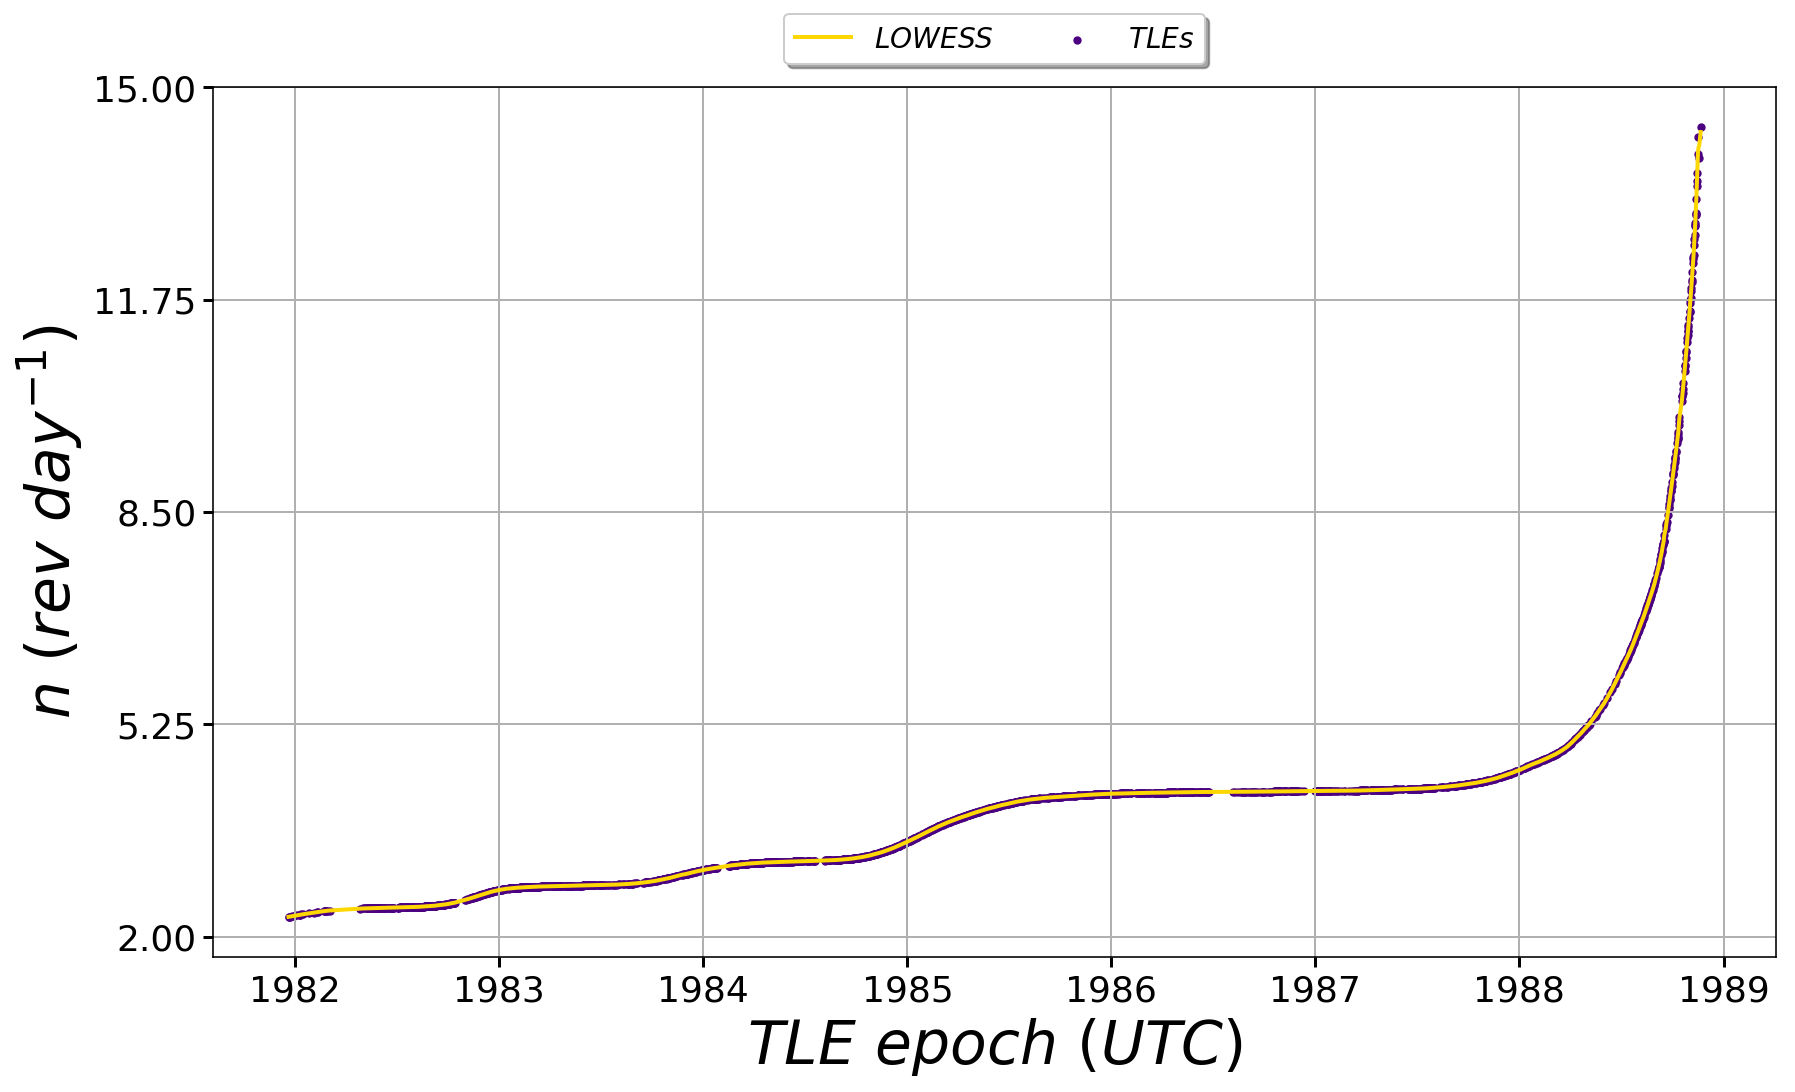

In [8]:
lwMeanMotions=sm.nonparametric.lowess(meanMotions,epochsJD,
                                      frac=2.98e-3, # Fraction of data
                                      # to use to smoothen each point.
                                      it=0, # No. re-weightings.
                                      delta=0, # Distance within which
                                      # unweighted regression
                                      # will be used.
                                      missing='raise',is_sorted=True,
                                      return_sorted=False)

fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,meanMotions,color='indigo',marker='o',s=10,
           label=r"$TLEs$")
ax.plot(epochs,lwMeanMotions,ls='-',lw=2,c='gold',label=r'$LOWESS$')
ax.set_ylabel(r"$n\ (rev\ day^{-1})$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(meanMotions.min(),lwMeanMotions.min()) # Bounds of the data.
upper=max(meanMotions.max(),lwMeanMotions.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5))
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=2)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()

## Inclination

Plot the smoothed $i$ time series and the original data. Use optimised LOWESS settings.

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


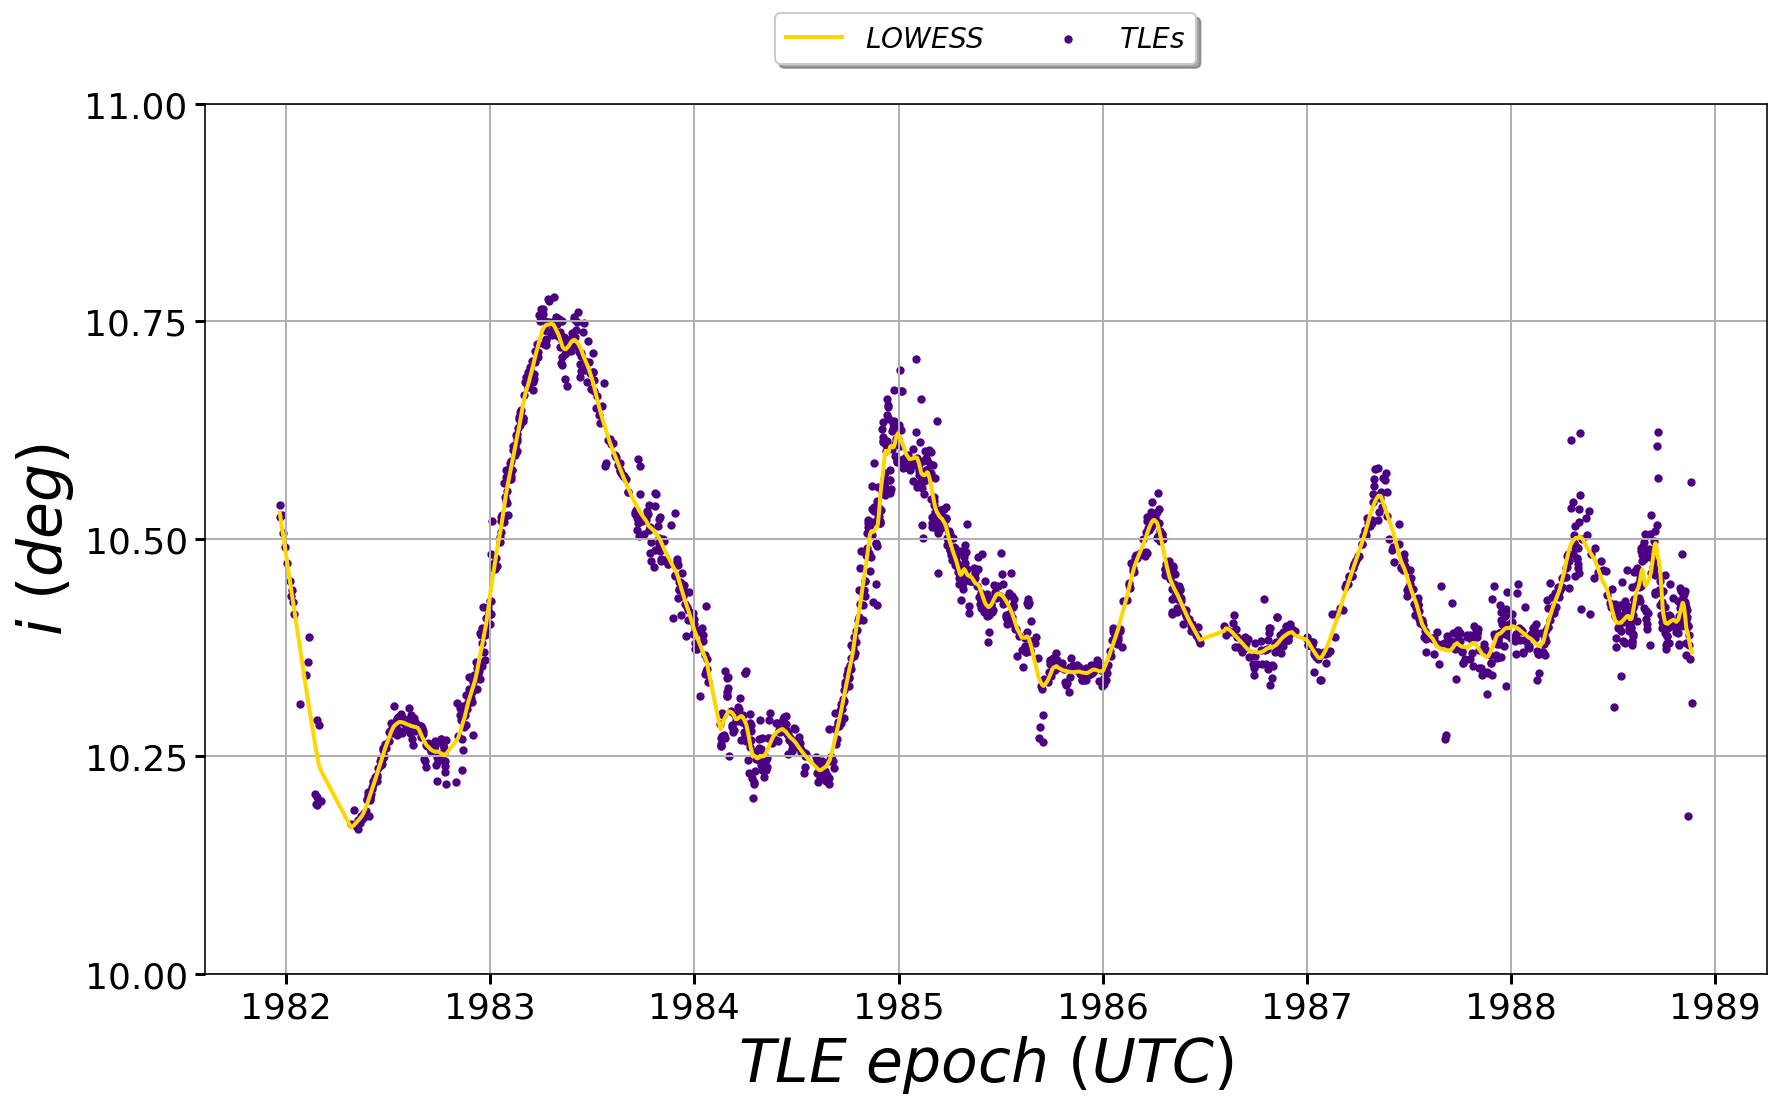

In [9]:
lwInclinations=sm.nonparametric.lowess(inclinations,epochsJD,
                                       frac=1.65e-2,it=0,delta=0,
                                       missing='raise',
                                       is_sorted=True,
                                       return_sorted=False)

fig,ax=matplotlib.pyplot.subplots(1,1,figsize=(14,8))
ax.scatter(epochs,inclinations,color='indigo',marker='o',s=10,
           label=r"$TLEs$")
ax.plot(epochs,lwInclinations,color='gold',lw=2.,ls='-',
        label=r"$LOWESS$")
ax.set_ylabel(r"$i\ (deg)$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(inclinations.min(),lwInclinations.min())
upper=max(inclinations.max(),lwInclinations.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.12),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=2)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$",fontsize=labelsFontSize)
fig.show()

## Eccentricity

Plot the smoothed $e$ time series and the original data. Use optimised LOWESS settings.

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


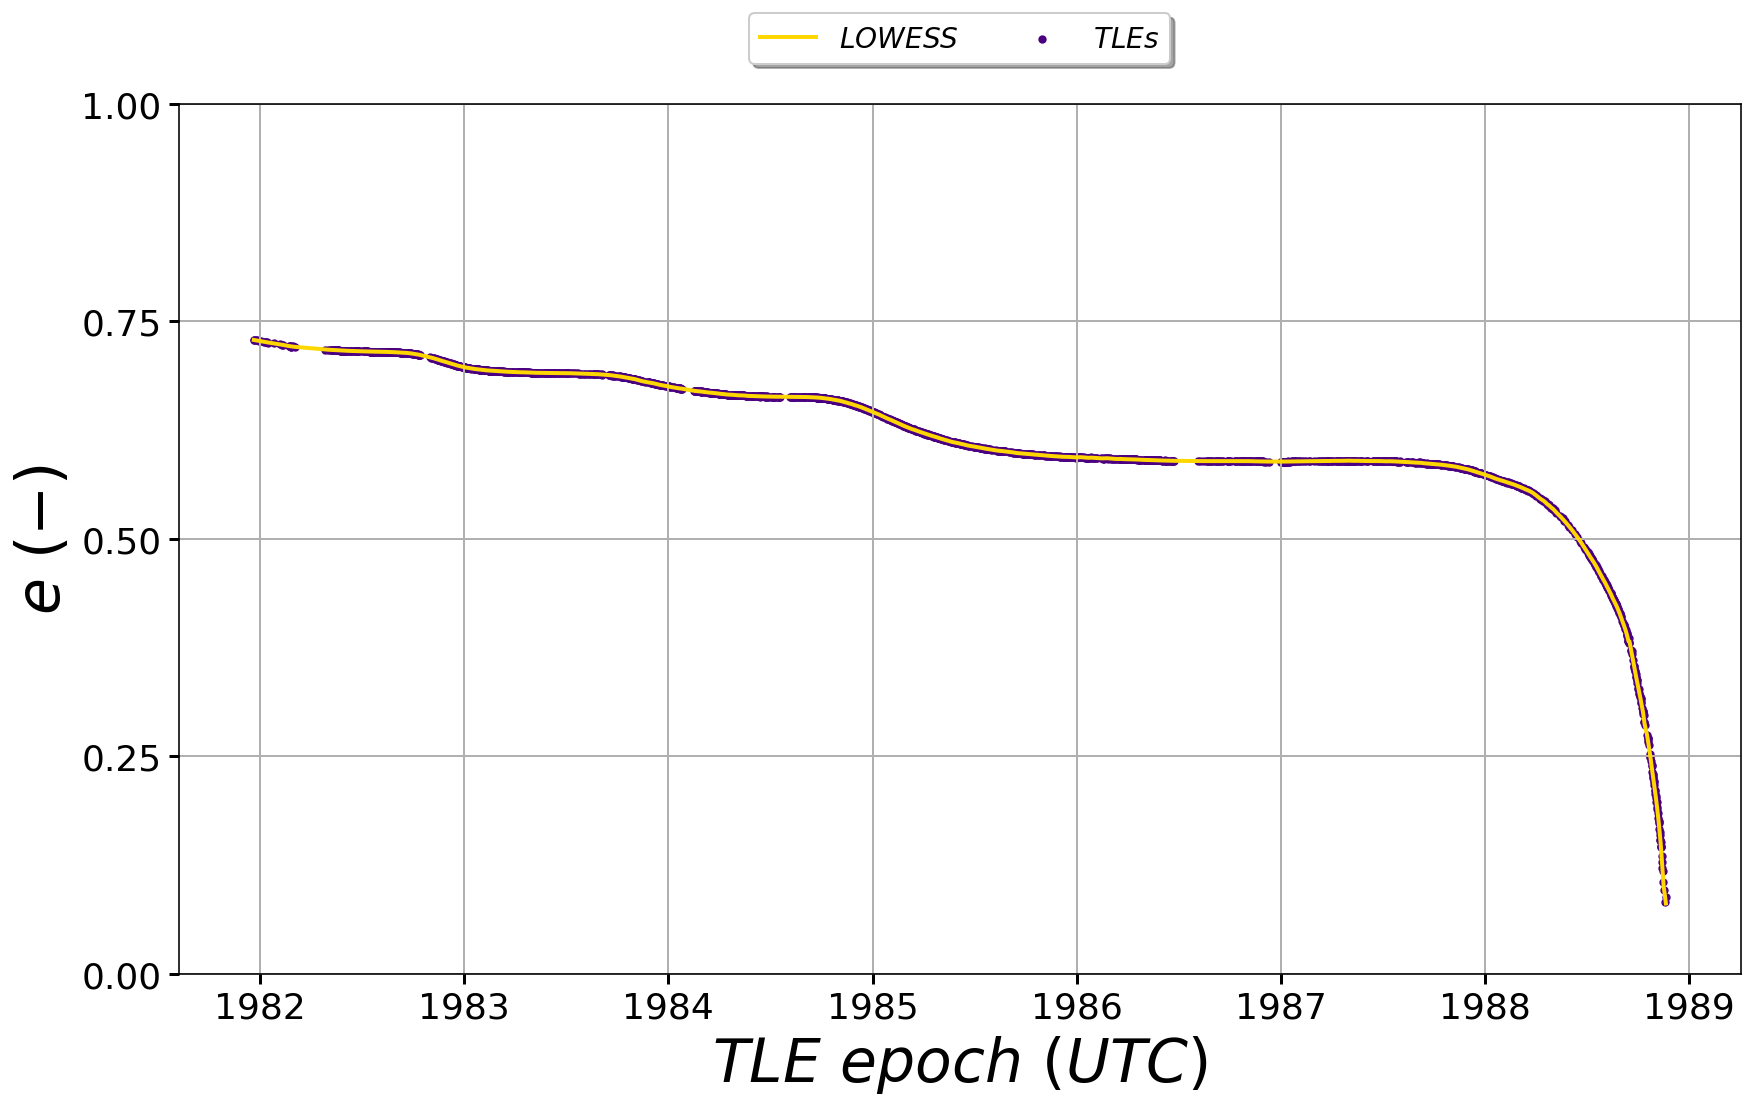

In [10]:
lwEccentricities=sm.nonparametric.lowess(eccentricities,epochsJD,
                                         frac=5.75e-3,it=0,delta=0,
                                         missing='raise',
                                         is_sorted=True,
                                         return_sorted=False)

fig,ax=matplotlib.pyplot.subplots(1,1,figsize=(14,8))
ax.scatter(epochs,eccentricities,color='indigo',marker='o',s=10,
           label=r"$TLEs$")
ax.plot(epochs,lwEccentricities,color='gold',lw=2.,ls='-',
        label=r"$LOWESS$")
ax.set_ylabel(r"$e\ (-)$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(eccentricities.min(),lwEccentricities.min())
upper=max(eccentricities.max(),lwEccentricities.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.12),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=2)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$",fontsize=labelsFontSize)
fig.show()

# Re-sample the time series

Interpolate the time series of $n$, $e$ and $i$ on a grid of equal spacing. Use one-day time spacing, which is pretty reasonable for TLE update frequency. At the end of this, we'll have a pristine time series.

In [11]:
import pandas as pd
assert pd.__version__>='0.18.1'

# Epochs at which we'll resample the data.
epochsJDResampled=numpy.arange(epochsJD[0],epochsJD[-1]+1e-3,1.0)
epochsResampled=pd.date_range(epochs[0],epochs[-1],freq='1D')

## Mean motion

Cubic interpolation seems to work well. Linear has sharp gradient changes at the beinning and end of time gaps, and quadratic has large overshoots. Behaviour across the time gaps is even worse for kernel-based approaches from `scikit.learn`, which have an even larger overshoot.

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


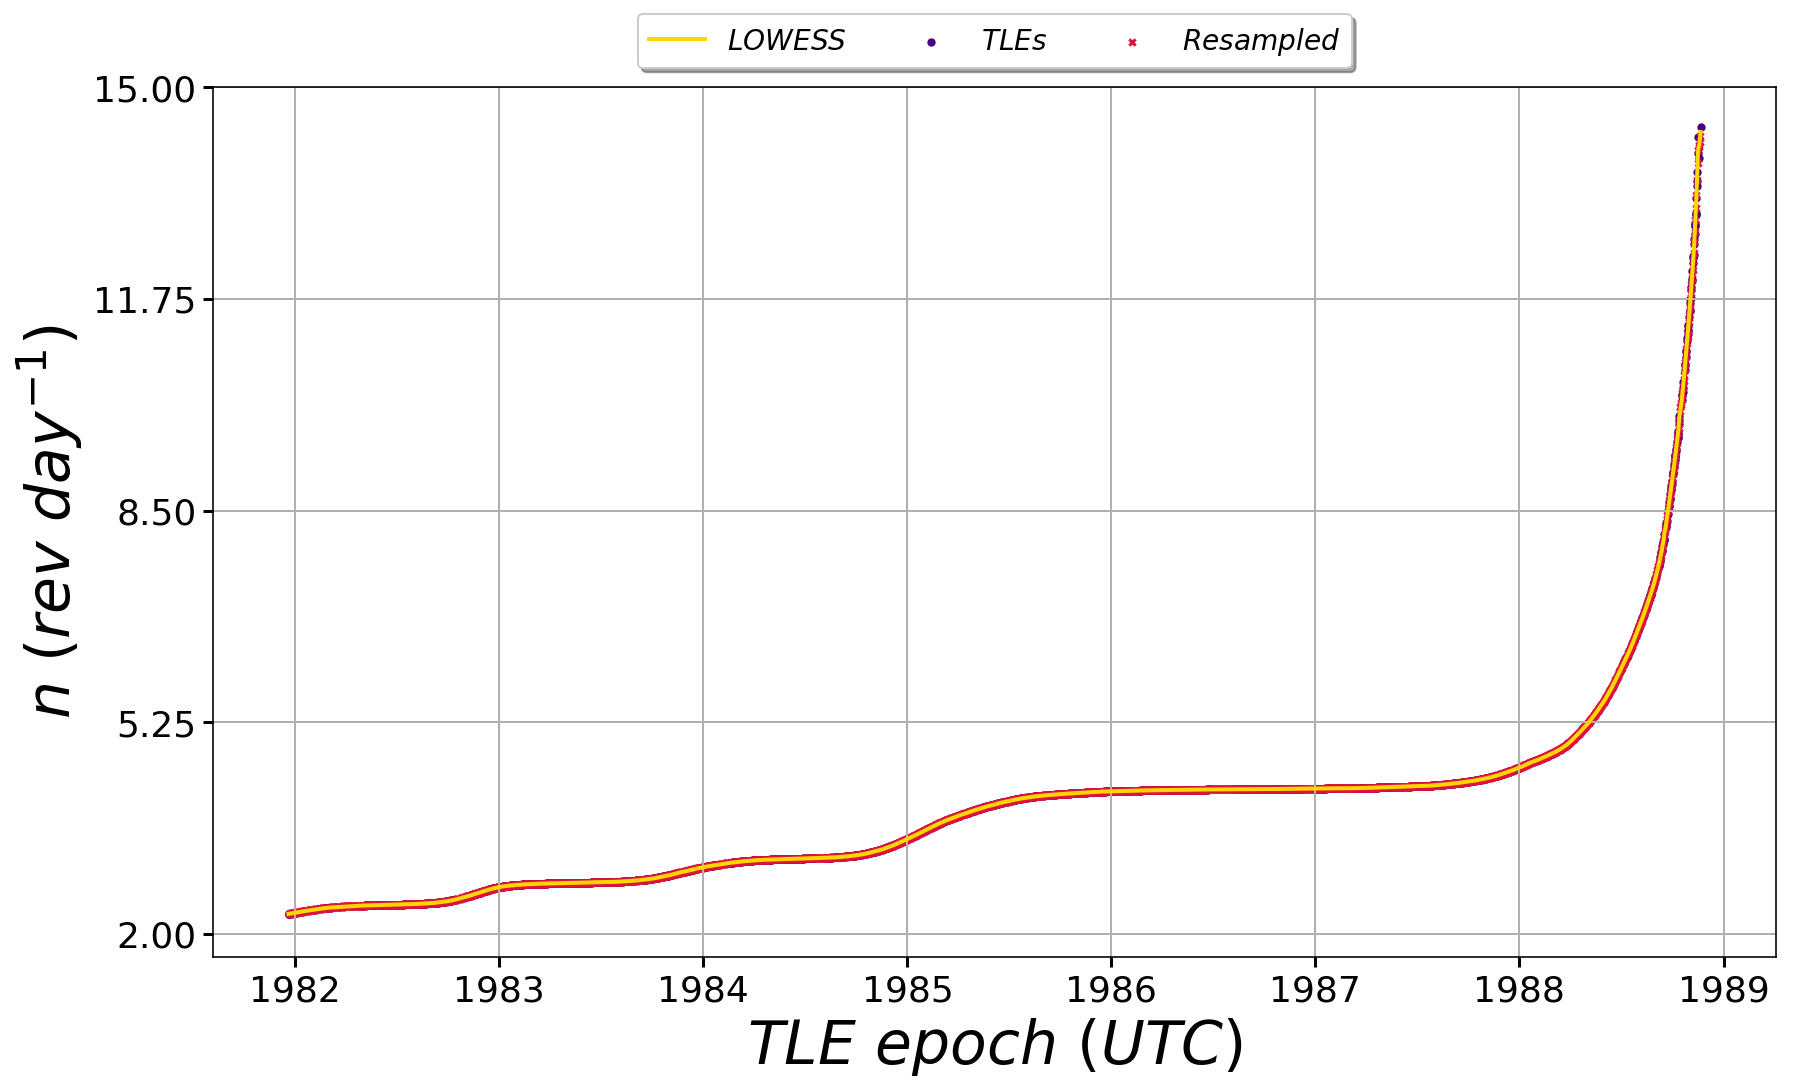

In [15]:
meanMotionInterp=scipy.interpolate.interp1d(epochsJD,lwMeanMotions,
                                            kind='cubic',
                                            bounds_error=True,
                                            assume_sorted=True)
meanMotionResampled=meanMotionInterp(epochsJDResampled)

fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,meanMotions,color='indigo',marker='o',s=10,
           label=r"$TLEs$")
ax.scatter(epochsResampled,meanMotionResampled,color='crimson',
           marker='x',s=10,label=r"$Resampled$")
ax.plot(epochs,lwMeanMotions,ls='-',lw=2,c='gold',label=r'$LOWESS$')
ax.set_ylabel(r"$n\ (rev\ day^{-1})$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(meanMotions.min(),lwMeanMotions.min(),meanMotionResampled.min())
upper=max(meanMotions.max(),lwMeanMotions.max(),meanMotionResampled.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()

## Eccentricity

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


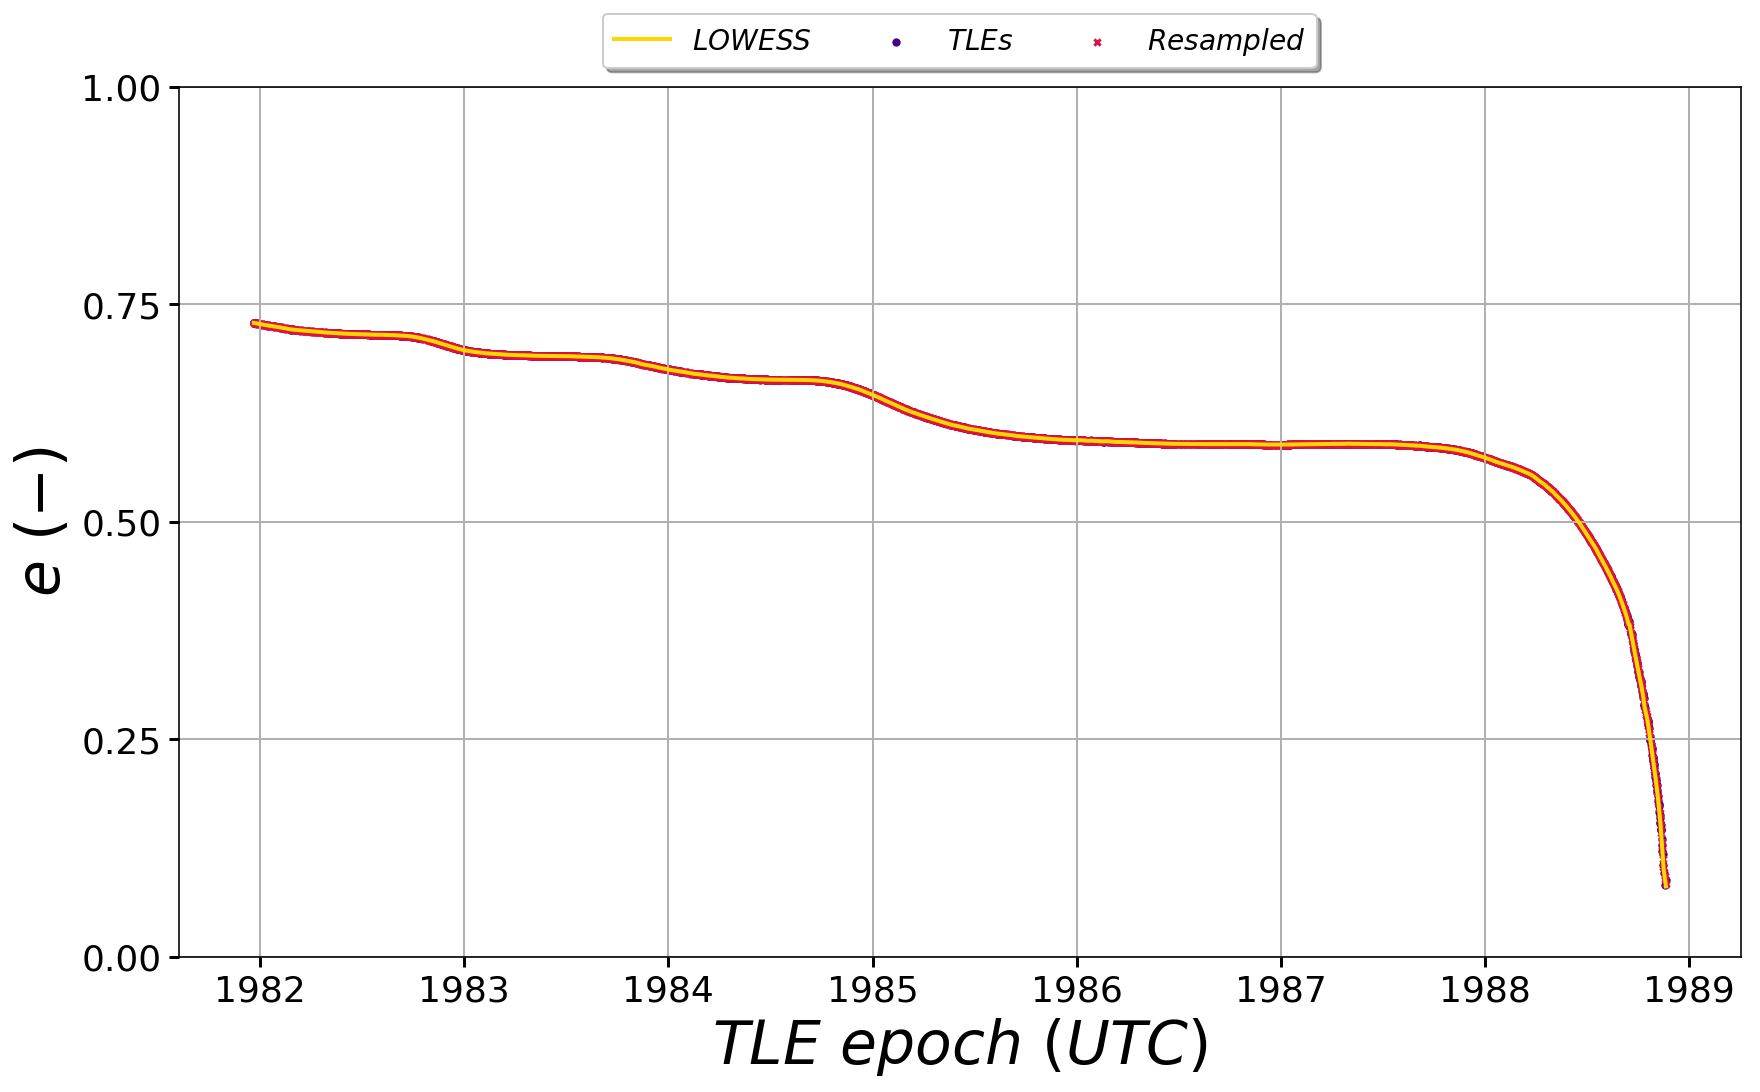

In [16]:
eccentricityInterp=scipy.interpolate.interp1d(epochsJD,lwEccentricities,
                                            kind='cubic',
                                            bounds_error=True,
                                            assume_sorted=True)
eccentricityResampled=eccentricityInterp(epochsJDResampled)

fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,eccentricities,color='indigo',marker='o',s=10,
           label=r"$TLEs$")
ax.scatter(epochsResampled,eccentricityResampled,color='crimson',
           marker='x',s=10,label=r"$Resampled$")
ax.plot(epochs,lwEccentricities,ls='-',lw=2,c='gold',label=r'$LOWESS$')
ax.set_ylabel(r"$e\ (-)$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(eccentricities.min(),lwEccentricities.min(),eccentricityResampled.min())
upper=max(eccentricities.max(),lwEccentricities.max(),eccentricityResampled.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()

## Incilination

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


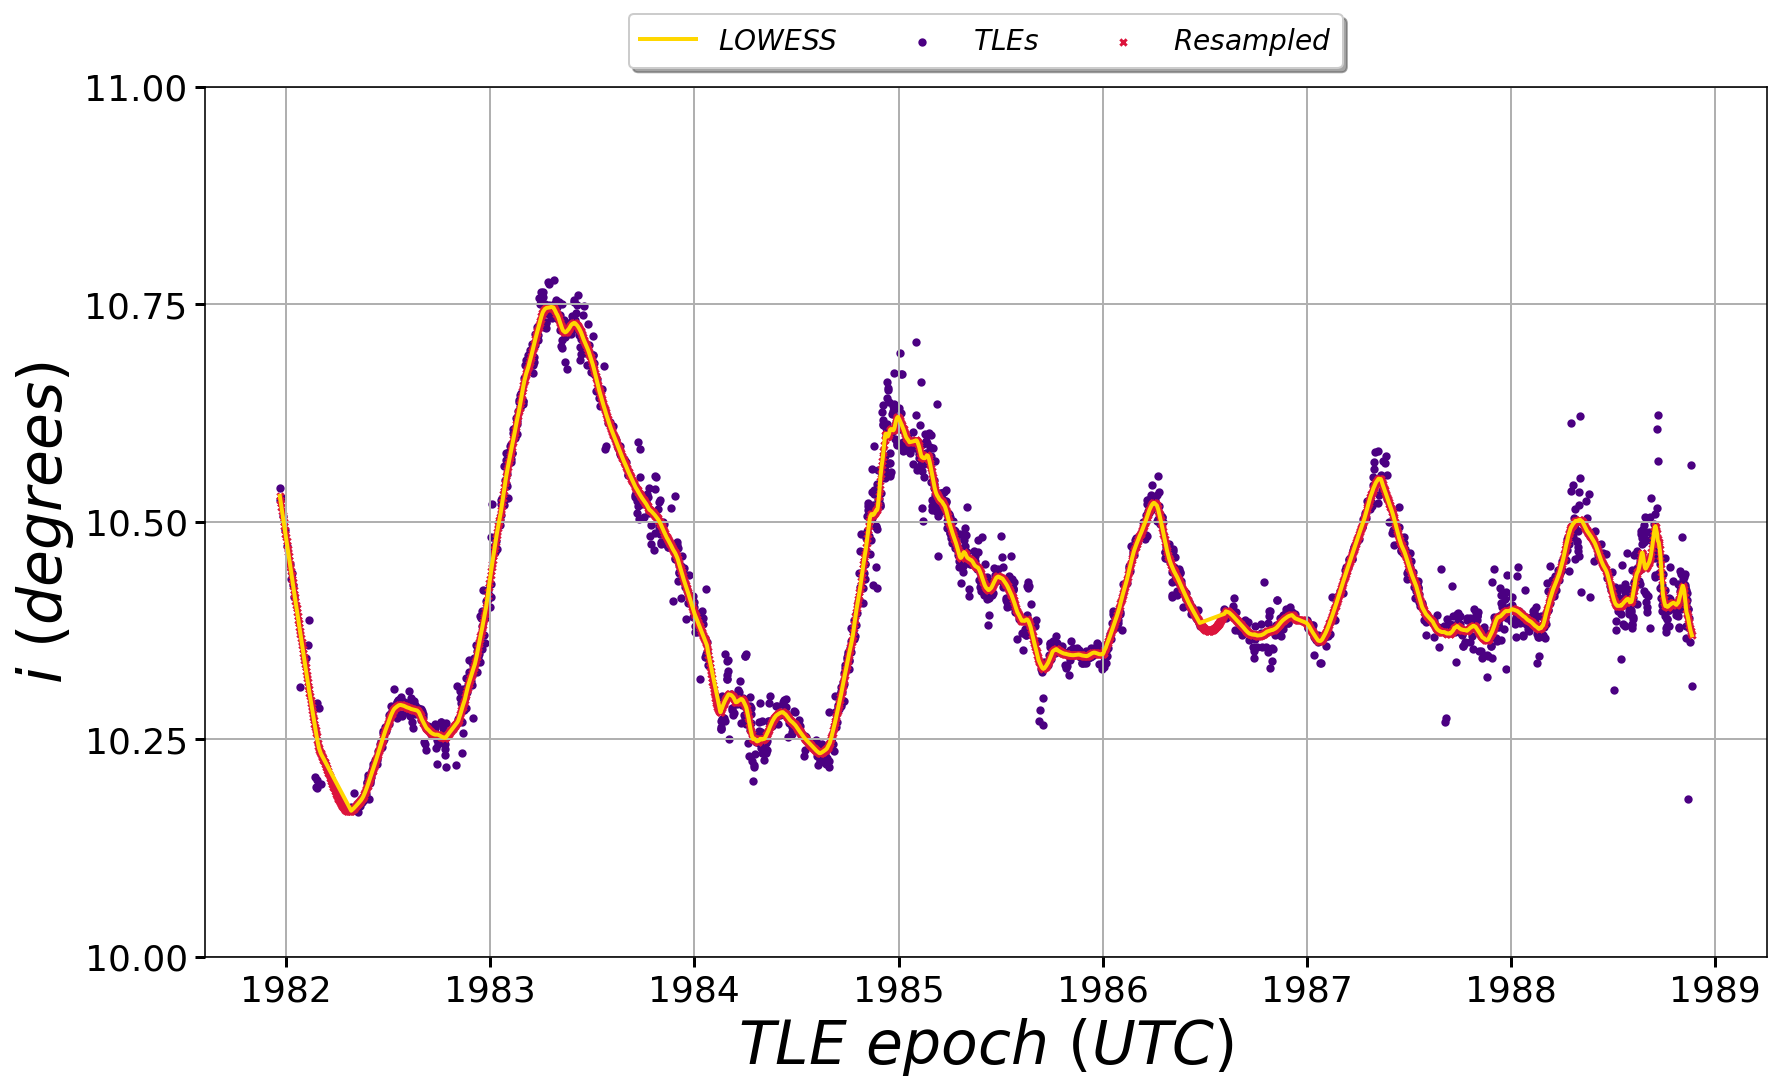

In [17]:
inclinationInterp=scipy.interpolate.interp1d(epochsJD,lwInclinations,
                                            kind='cubic',
                                            bounds_error=True,
                                            assume_sorted=True)
inclinationResampled=inclinationInterp(epochsJDResampled)

fig,ax=matplotlib.pyplot.subplots(1,1,sharex=True,figsize=(14,8))
ax.scatter(epochs,inclinations,color='indigo',marker='o',s=10,
           label=r"$TLEs$")
ax.scatter(epochsResampled,inclinationResampled,color='crimson',
           marker='x',s=10,label=r"$Resampled$")
ax.plot(epochs,lwInclinations,ls='-',lw=2,c='gold',label=r'$LOWESS$')
ax.set_ylabel(r"$i\ (degrees)$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
lower=min(inclinations.min(),lwInclinations.min(),inclinationResampled.min())
upper=max(inclinations.max(),lwInclinations.max(),inclinationResampled.max())
ax.set_yticks(numpy.linspace(numpy.floor(lower),numpy.ceil(upper),5) )
ax.legend(bbox_to_anchor=(0.5,1.1),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=3)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xlabel(r"$TLE\ epoch\ (UTC)$", size=labelsFontSize)
fig.show()